# Loading the data

In [1]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [28]:
df_top_100 = pd.read_csv("/content/2024_spotify_top_100_cleaned.csv")
df_obama = pd.read_csv("/content/barack_obamas_playlist_2019-2023_clean_enriched.csv")

#Data Exploration

In [52]:
print("Spotify's top 100 streamed songs' dataframe has", df_top_100.shape[0], "songs and", df_top_100.shape[1], "attributes.")
print()
print("Obama's playlists' dataframe shape has",df_obama.shape[0], "songs and", df_obama.shape[1], "attributes.")

Spotify's top 100 streamed songs' dataframe has 100 songs and 21 attributes.

Obama's playlists' dataframe shape has 257 songs and 25 attributes.


In [53]:
df_obama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  257 non-null    object 
 1   track_name                257 non-null    object 
 2   track_album_name          257 non-null    object 
 3   track_artist              257 non-null    object 
 4   artist_id                 257 non-null    object 
 5   artist_followers          257 non-null    int64  
 6   artist_popularity         257 non-null    int64  
 7   artist_gender             213 non-null    object 
 8   track_album_release_year  257 non-null    object 
 9   duration_min              257 non-null    object 
 10  track_popularity          257 non-null    int64  
 11  genres                    257 non-null    object 
 12  record_label              257 non-null    object 
 13  danceability              257 non-null    float64
 14  energy    

In [54]:
df_top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  100 non-null    object 
 1   track_name                100 non-null    object 
 2   track_artist              100 non-null    object 
 3   track_popularity          100 non-null    int64  
 4   track_album_name          100 non-null    object 
 5   track_album_release_year  100 non-null    int64  
 6   duration_min              100 non-null    float64
 7   genres                    100 non-null    object 
 8   record_label              100 non-null    object 
 9   danceability              100 non-null    float64
 10  energy                    100 non-null    float64
 11  key_name                  100 non-null    object 
 12  loudness                  100 non-null    float64
 13  mode                      100 non-null    object 
 14  speechiness

#Data cleaning

In [29]:
for feature in ["valence", "danceability", "loudness", "energy", "acousticness", "instrumentalness", "liveness", "speechiness"]:
  df_obama[feature] = df_obama[feature].str.replace(',', '.').astype(float)

In [30]:
for feature in ["valence", "danceability", "energy", "acousticness", "instrumentalness", "liveness", "speechiness"]:
  df_top_100[feature] = df_top_100[feature].str.replace('%', '').astype(float)

In [55]:
df_obama["track_album_release_year"] = df_obama["track_album_release_year"].str.replace(r'\D', '', regex=True).astype(int)

In [88]:
df_obama["duration_min"] = df_obama["duration_min"].str.replace(',', '.').astype(float)

In [21]:
df_top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  100 non-null    object 
 1   track_name                100 non-null    object 
 2   track_artist              100 non-null    object 
 3   track_popularity          100 non-null    int64  
 4   track_album_name          100 non-null    object 
 5   track_album_release_year  100 non-null    int64  
 6   duration_min              100 non-null    float64
 7   genres                    100 non-null    object 
 8   record_label              100 non-null    object 
 9   danceability              100 non-null    float64
 10  energy                    100 non-null    float64
 11  key_name                  100 non-null    object 
 12  loudness                  100 non-null    float64
 13  mode                      100 non-null    object 
 14  speechiness

In [89]:
df_obama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  257 non-null    object 
 1   track_name                257 non-null    object 
 2   track_album_name          257 non-null    object 
 3   track_artist              257 non-null    object 
 4   artist_id                 257 non-null    object 
 5   artist_followers          257 non-null    int64  
 6   artist_popularity         257 non-null    int64  
 7   artist_gender             213 non-null    object 
 8   track_album_release_year  257 non-null    int64  
 9   duration_min              257 non-null    float64
 10  track_popularity          257 non-null    int64  
 11  genres                    257 non-null    object 
 12  record_label              257 non-null    object 
 13  danceability              257 non-null    float64
 14  energy    

#Musical features Exploration


##Genres comparison

In [36]:
# Compute the sorted counts for the first DataFrame
sorted_counts_obama = df_obama["genres"].value_counts().sort_values(ascending=False)
sorted_genres_obama = sorted_counts_obama.index.tolist()

# Compute the sorted counts for the second DataFrame
sorted_counts_top_100 = df_top_100["genres"].value_counts().sort_values(ascending=False)
sorted_genres_top_100 = sorted_counts_top_100.index.tolist()

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Obama Genres Count", "Top 100 Genres Count"))

# Create first bar chart (sorted) and add it to the first column
fig_obama = px.bar(
    x=sorted_genres_obama,
    y=sorted_counts_obama,
    title="Genres Count for Obama",
    labels={'x': 'Genres', 'y': 'Count'}
)
for trace in fig_obama['data']:
    fig.add_trace(trace, row=1, col=1)

# Create second bar chart (sorted) and add it to the second column
fig_top_100 = px.bar(
    x=sorted_genres_top_100,
    y=sorted_counts_top_100,
    title="Genres Count for Top 100",
    labels={'x': 'Genres', 'y': 'Count'}
)
for trace in fig_top_100['data']:
    fig.add_trace(trace, row=1, col=2)

# Update layout to fit the titles and adjust the appearance
fig.update_layout(title_text="Comparison of Genres Count (Sorted by Count)", showlegend=False)

# Show the combined plot
fig.show()

##Artists

In [42]:

# Group and sort by artist for the Obama dataset
grouped_by_artist_obama = df_obama.groupby("track_artist").count()
top_artists_obama = grouped_by_artist_obama.sort_values("track_name", ascending=False).head(20)

# Group and sort by artist for the Top 100 dataset
grouped_by_artist_top_100 = df_top_100.groupby("track_artist").count()
top_artists_top_100 = grouped_by_artist_top_100.sort_values("track_name", ascending=False).head(20)

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 20 Artists by Track Count (Obama)", "Top 20 Artists by Track Count (Top 100)"))

# Create bar chart for the Obama dataset and add to first column
fig_obama = px.bar(
    top_artists_obama,
    x=top_artists_obama.index,
    y="track_name",
    title="Top 20 Artists by Track Count (Obama)",
    labels={'x': 'Artist', 'track_name': 'Track Count'}
)
for trace in fig_obama['data']:
    fig.add_trace(trace, row=1, col=1)

# Create bar chart for the Top 100 dataset and add to second column
fig_top_100 = px.bar(
    top_artists_top_100,
    x=top_artists_top_100.index,
    y="track_name",
    title="Top 20 Artists by Track Count (Top 100)",
    labels={'x': 'Artist', 'track_name': 'Track Count'}
)
for trace in fig_top_100['data']:
    fig.add_trace(trace, row=1, col=2)

# Update layout for better readability and set y-axis range for the second plot
fig.update_layout(
    title_text="Top 20 Artists by Track Count Comparison",
    showlegend=False,
    xaxis_tickangle=-45,
    xaxis2_tickangle=-45,
    yaxis2_range=[0, 8.5]  # Sets the y-axis range for the second plot (Top 100 dataset) to go up to 8
)

# Show the combined plot
fig.show()

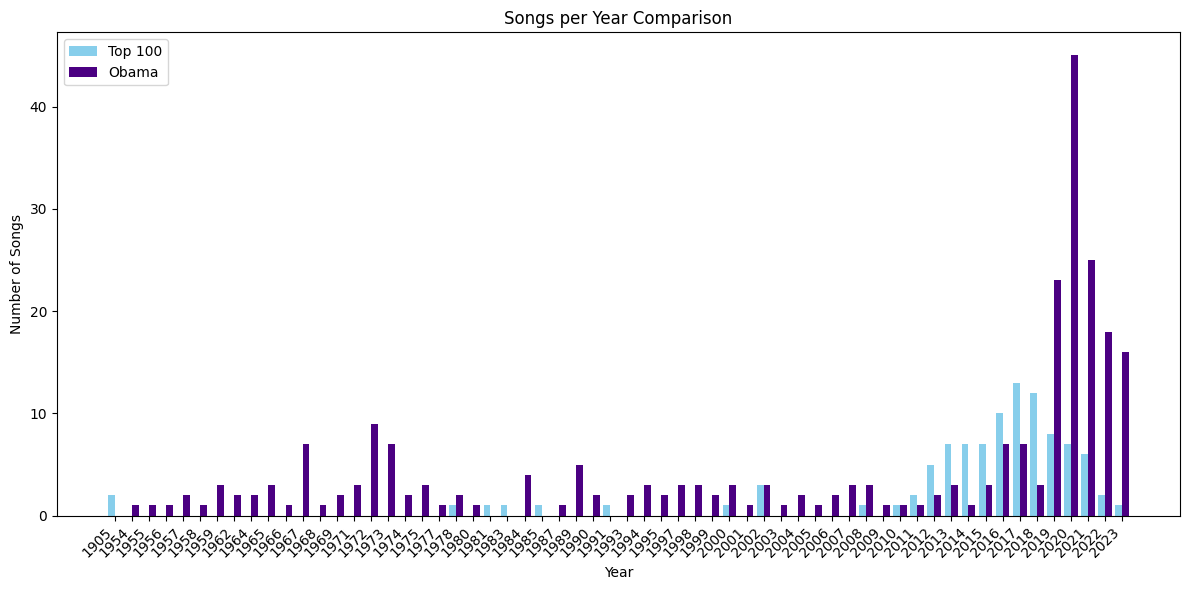

In [65]:
# Create the figure and axis
plt.figure(figsize=(12, 6))  # Increase the figure size for better readability

# Set the positions for the bars
x_top_100 = np.arange(len(df_top_100_grouped_by_year)) * 2  # Increase the spacing between bars
x_obama = x_top_100 + 0.8  # Shift Obama bars further to the right

# Plot the Top 100 dataset with a specific color and label
plt.bar(x_top_100,
        df_top_100_grouped_by_year['track_name'],
        color='skyblue',
        width=0.8,  # Increase width to make the bars more visible
        label='Top 100')

# Plot the Obama dataset with a different color and label
plt.bar(x_obama,
        df_obama_grouped_by_year['track_name'],
        color='indigo',
        width=0.8,  # Increase width to make the bars more visible
        label='Obama')

# Set the x-ticks to show the years correctly with larger spacing
plt.xticks(x_top_100 + 0.4, years, rotation=45, ha='right')  # Rotate and adjust the alignment of x-ticks

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Songs per Year Comparison')
plt.legend()

# Display the plot
plt.tight_layout()  # Automatically adjust the layout for better fit
plt.show()




In [68]:
print("The oldest song in the Top 100 streamed songs on Spotify as of 2024 is from the year",df_top_100["track_album_release_year"].min())

The oldest song in the Top 100 streamed songs on Spotify as of 2024 is from the year 1905 .


In [69]:
df_top_100[df_top_100["track_album_release_year"] == 1905]

,track_id,track_name,track_artist,track_popularity,track_album_name,track_album_release_year,duration_min,genres,record_label,danceability,...,key_name,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
51,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers,85,Hot Fuss,1905,3.72,Rock,Island Records,35.2,...,C#,-5.23,Major,7.47,0.12,0.0,9.95,23.6,148.03,4
77,60a0Rd6pjrkxjPbaKzXjfq,In the End,Linkin Park,87,Hybrid Theory (Bonus Edition),1905,3.61,Rap,Warner Records,55.6,...,D#,-5.87,Minor,5.84,0.96,0.0,20.90,40.0,105.14,4


There might be an error here 😆

In [71]:
#The Killers' Mr. Brightside was actually released in 2004, and Linkin Park's In the End, in 2000. Let's update those rows.

df_top_100.loc[df_top_100["track_name"] == "Mr. Brightside", "track_album_release_year"] = 2004
df_top_100.loc[df_top_100["track_name"] == "In the End", "track_album_release_year"] = 2000

In [74]:
print("The oldest song in the Top 100 streamed songs on Spotify as of 2024 is from the year",df_top_100["track_album_release_year"].min())
print("The oldest song in Obama's playlists is from the year",df_obama["track_album_release_year"].min())

The oldest song in the Top 100 streamed songs on Spotify as of 2024 is from the year 1978
The oldest song in Obama's playlists is from the year 1954


In [79]:
df_top_100[df_top_100["track_album_release_year"] == 1978]

,track_id,track_name,track_artist,track_popularity,track_album_name,track_album_release_year,duration_min,genres,record_label,danceability,...,key_name,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
87,5T8EDUDqKcs6OSOwEsfqG7,Don't Stop Me Now - Remastered 2011,Queen,81,Jazz (2011 Remaster),1978,3.49,Rock,EMI,55.9,...,F,-5.276,Major,17.0,4.75,0.02,77.6,60.9,156.3,4


In [80]:
df_obama[df_obama["track_album_release_year"] == 1954]

,track_id,track_name,track_album_name,track_artist,artist_id,artist_followers,artist_popularity,artist_gender,track_album_release_year,duration_min,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
111,2cvztQuBIxwV38kg1Ydaww,How High The Moon - 1st Take,Lullabies Of Birdland,Ella Fitzgerald,5V0MlUE1Bft0mbLlND7FJz,2552446,69,F,1954,"3,26",...,F,-5.18,minor,0.1,0.81,0.0,0.11,0.63,113,4


In [86]:
print("Average track popularity for Obama's playlists: ", round(df_obama["track_popularity"].mean(),2))
print("Average track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].mean(),2))

print("")

print("Median track popularity for Obama's playlists: ", round(df_obama["track_popularity"].median(),2))
print("Median track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].median(),2))

print("")

print("Max track popularity for Obama's playlists: ", round(df_obama["track_popularity"].max(),2))
print("Max track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].max(),2))

print("")

print("Min track popularity for Obama's playlists: ", round(df_obama["track_popularity"].min(),2))
print("Min track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].min(),2))


Average track popularity for Obama's playlists:  41.76
Average track popularity for the 100 streamed songs as of 2024:  81.05

Median track popularity for Obama's playlists:  46.0
Median track popularity for the 100 streamed songs as of 2024:  82.0

Max track popularity for Obama's playlists:  85
Max track popularity for the 100 streamed songs as of 2024:  90

Min track popularity for Obama's playlists:  0
Min track popularity for the 100 streamed songs as of 2024:  52


In [117]:
print("Average track duration for Obama's playlists: ", round(df_obama["duration_min"].mean(),2))
print("Average track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].mean(),2))

print("")

print("Standard deviation of track duration for Obama's playlists: ", round(df_obama["duration_min"].std(),2))
print("Standard deviation of track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].std(),2))

print("")

print("Median track duration for Obama's playlists: ", round(df_obama["duration_min"].median(),2))
print("Median track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].median(),2))

print("")

print("Max track duration for Obama's playlists: ", round(df_obama["duration_min"].max(),2))
print("Max track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].max(),2))

print("")

print("Min track duration for Obama's playlists: ", round(df_obama["duration_min"].min(),2))
print("Min track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].min(),2))

Average track duration for Obama's playlists:  3.83
Average track duration for the 100 streamed songs as of 2024:  3.71

Standard deviation of track duration for Obama's playlists:  1.12
Standard deviation of track duration for the 100 streamed songs as of 2024:  0.69

Median track duration for Obama's playlists:  3.64
Median track duration for the 100 streamed songs as of 2024:  3.58

Max track duration for Obama's playlists:  10.72
Max track duration for the 100 streamed songs as of 2024:  5.92

Min track duration for Obama's playlists:  1.45
Min track duration for the 100 streamed songs as of 2024:  1.99


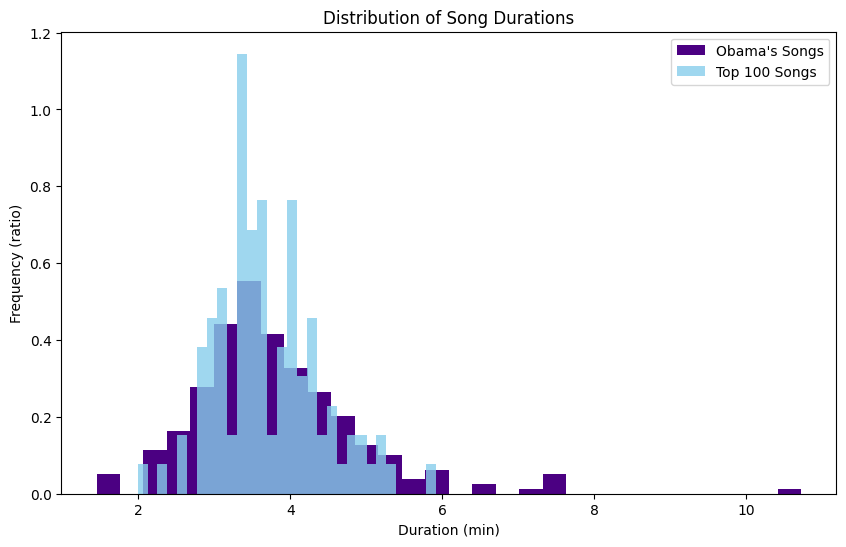

In [115]:
plt.figure(figsize=(10, 6))

# Plot the Obama dataset histogram with normalized frequency (density)
plt.hist(df_obama['duration_min'], bins=30, color='indigo', alpha=1, density=True, label="Obama's Songs")

# Plot the Top 100 dataset histogram with normalized frequency (density)
plt.hist(df_top_100['duration_min'], bins=30, color='skyblue', alpha=0.8, density=True, label='Top 100 Songs')

# Labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Frequency (ratio)')
plt.title('Distribution of Song Durations')

# Add a legend to differentiate the two distributions
plt.legend()

# Display the plot
plt.show()

##Music & sonic Features

###Valence 🎭

In [130]:
print("Average track valence for Obama's playlists: ",round(df_obama["valence"].mean()*100,2),"%.")
print("Average track valence for the 100 streamed songs as of 2024: ",round(df_top_100["valence"].mean(),2),"%.")

Average track valence for Obama's playlists:  56.42 %.
Average track valence for the 100 streamed songs as of 2024:  48.91 %.


###Danceability 💃

In [123]:
print("Average track danceability for Obama's playlists: ",round(df_obama["danceability"].mean()*100,2),"%.")
print("Average track danceability for the 100 streamed songs as of 2024: ",round(df_top_100["danceability"].mean(),2),"%.")

Average track danceability for Obama's playlists:  63.41 %.
Average track danceability for the 100 streamed songs as of 2024:  63.81 %.


###Energy 🥄

In [124]:
print("Average track energy for Obama's playlists: ",round(df_obama["energy"].mean()*100,2),"%.")
print("Average track energy for the 100 streamed songs as of 2024: ",round(df_top_100["energy"].mean(),2),"%.")

Average track energy for Obama's playlists:  59.96 %.
Average track energy for the 100 streamed songs as of 2024:  62.74 %.


###Loudness 🔊

In [125]:
print("Average track loudness for Obama's playlists: ",round(df_obama["loudness"].mean(),2),"dB.")
print("Average track loudness for the 100 streamed songs as of 2024: ",round(df_top_100["loudness"].mean(),2),"dB.")

Average track loudness for Obama's playlists:  -8.26 dB.
Average track loudness for the 100 streamed songs as of 2024:  -6.2 dB.


###Speechiness 🗣

In [126]:
print("Average track speechiness for Obama's playlists: ",round(df_obama["speechiness"].mean()*100,2),"%.")
print("Average track speechiness for the 100 streamed songs as of 2024: ",round(df_top_100["speechiness"].mean(),2),"%.")

Average track speechiness for Obama's playlists:  10.49 %.
Average track speechiness for the 100 streamed songs as of 2024:  8.59 %.


###Instrumentalness 🎼

In [127]:
print("Average track instrumentalness for Obama's playlists: ",round(df_obama["instrumentalness"].mean()*100,2),"%.")
print("Average track instrumentalness for the 100 streamed songs as of 2024: ",round(df_top_100["instrumentalness"].mean(),2),"%.")

Average track instrumentalness for Obama's playlists:  3.02 %.
Average track instrumentalness for the 100 streamed songs as of 2024:  0.77 %.


###Acousticness 🎙

In [128]:
print("Average track acousticness for Obama's playlists: ",round(df_obama["acousticness"].mean()*100,2),"%.")
print("Average track acousticness for the 100 streamed songs as of 2024: ",round(df_top_100["acousticness"].mean(),2),"%.")

Average track acousticness for Obama's playlists:  27.58 %.
Average track acousticness for the 100 streamed songs as of 2024:  25.32 %.


###Liveness 🥁

In [129]:
print("Average track liveness for Obama's playlists: ",round(df_obama["liveness"].mean()*100,2),"%.")
print("Average track liveness for the 100 streamed songs as of 2024: ",round(df_top_100["liveness"].mean(),2),"%.")

Average track liveness for Obama's playlists:  17.88 %.
Average track liveness for the 100 streamed songs as of 2024:  16.1 %.


In [132]:
df_obama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  257 non-null    object 
 1   track_name                257 non-null    object 
 2   track_album_name          257 non-null    object 
 3   track_artist              257 non-null    object 
 4   artist_id                 257 non-null    object 
 5   artist_followers          257 non-null    int64  
 6   artist_popularity         257 non-null    int64  
 7   artist_gender             213 non-null    object 
 8   track_album_release_year  257 non-null    int64  
 9   duration_min              257 non-null    float64
 10  track_popularity          257 non-null    int64  
 11  genres                    257 non-null    object 
 12  record_label              257 non-null    object 
 13  danceability              257 non-null    float64
 14  energy    

In [143]:
# Compute the time signature counts for both DataFrames
obama_time_signatures = df_obama["time_signature"].value_counts(normalize=True).rename("Obama")
top_100_time_signatures = df_top_100["time_signature"].value_counts(normalize=True).rename("Top 100")

# Combine both counts into a single DataFrame
combined_time_signatures = pd.concat([obama_time_signatures, top_100_time_signatures], axis=1)

# Fill NaN values with 0 if some time signatures don't appear in both datasets
combined_time_signatures = combined_time_signatures.fillna(0)

# Convert ratios to percentages and round to the nearest integer
combined_time_signatures = combined_time_signatures * 100
combined_time_signatures = combined_time_signatures.round(0).astype(int)

# Display the combined table with ratios
print(combined_time_signatures)

                Obama  Top 100
time_signature                
4                  92       98
3                   7        2
1                   1        0
5                   1        0


In [144]:
# Compute the mode counts for both DataFrames
obama_modes = df_obama["mode"].value_counts(normalize=True).rename("Obama")
top_100_modes = df_top_100["mode"].value_counts(normalize=True).rename("Top 100")

# Combine both counts into a single DataFrame
combined_modes = pd.concat([obama_modes, top_100_modes], axis=1)

# Fill NaN values with 0 if some time signatures don't appear in both datasets
combined_modes = combined_modes.fillna(0)

# Convert ratios to percentages and round to the nearest integer
combined_modes = combined_modes * 100
combined_modes = combined_modes.round(0).astype(int)

# Display the combined table with ratios
print(combined_modes)

       Obama  Top 100
mode                 
Major     58       65
minor     42        0
Minor      0       35


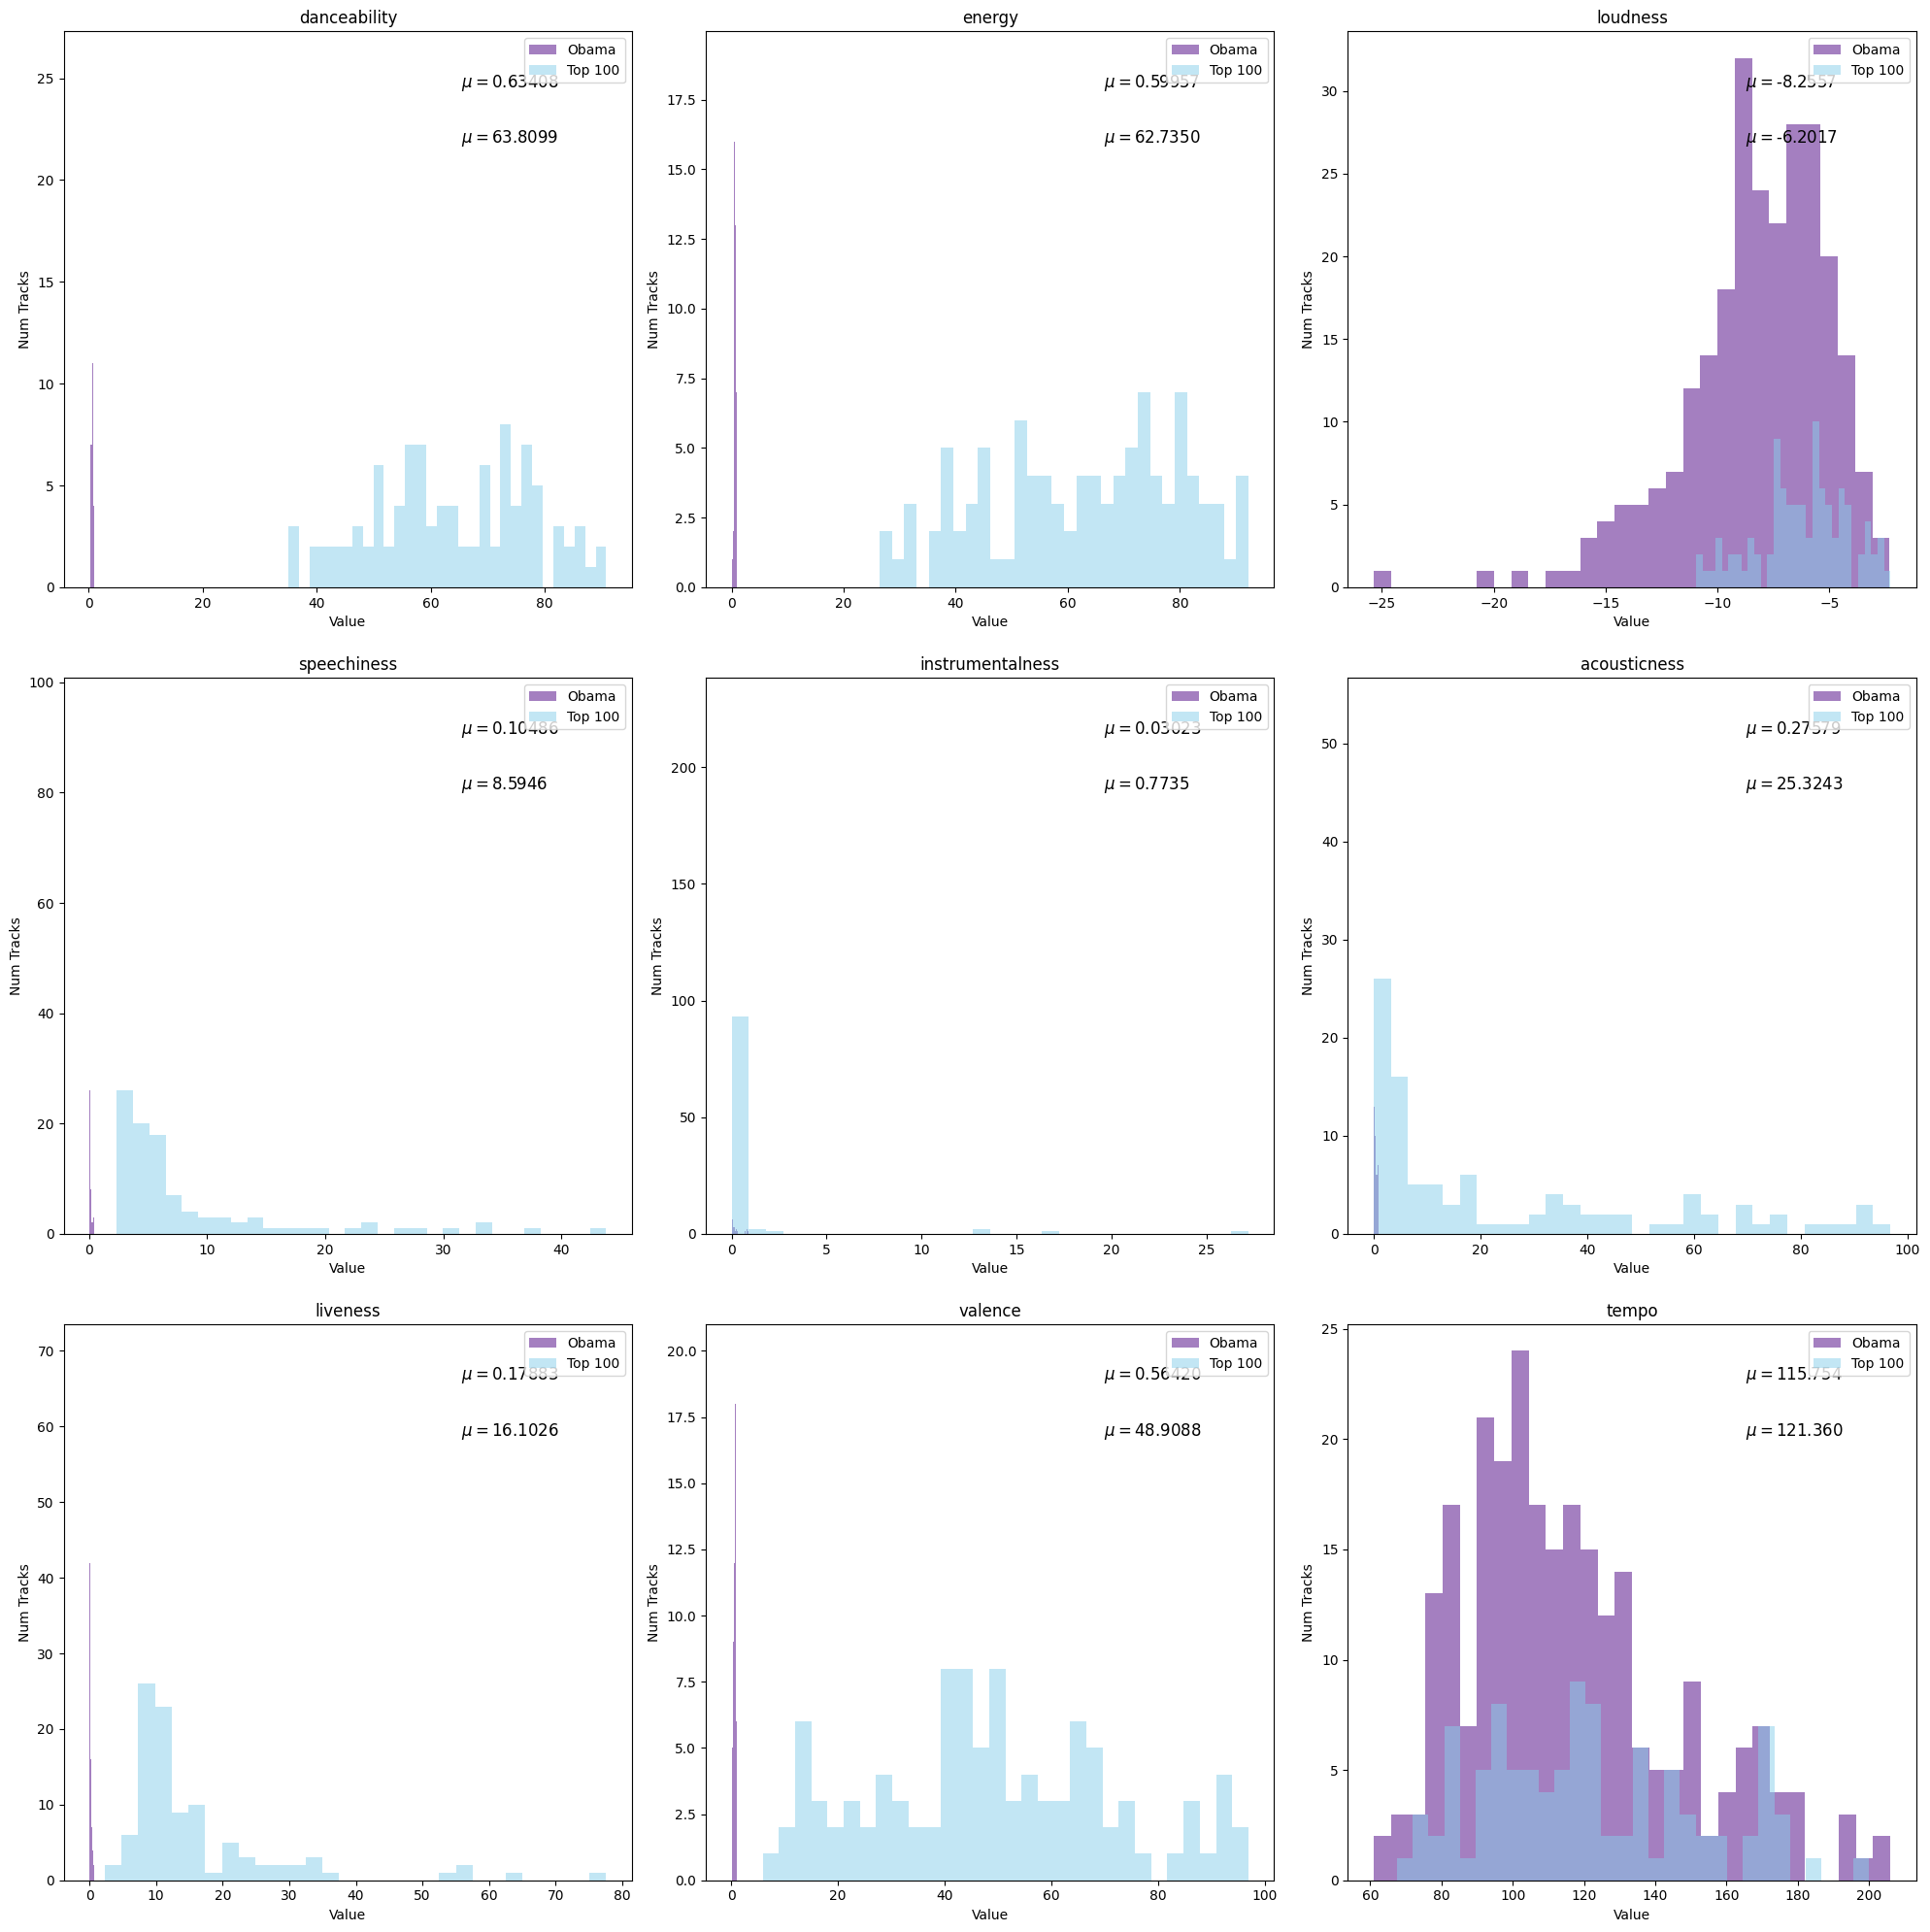

In [148]:

plt.figure(figsize=(20, 20))

# Overlay histograms for each category
for i, category in enumerate(['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'acousticness', 'liveness', 'valence', 'tempo']):
    plt.subplot(3, 3, i + 1)

    # Plot the Obama dataset histogram with transparency
    plt.hist(df_obama[category], bins=30, alpha=0.5, label='Obama', color='indigo')

    # Plot the Top 100 dataset histogram with transparency
    plt.hist(df_top_100[category], bins=30, alpha=0.5, label='Top 100', color='skyblue')

    # Display the mean for Obama dataset
    plt.text(plt.xlim()[1] - (plt.xlim()[1] - plt.xlim()[0]) * 0.3,
             plt.ylim()[1] * 0.9, r'$\mu=$' + str(df_obama[category].mean())[:7], fontsize=12)

    # Display the mean for Top 100 dataset
    plt.text(plt.xlim()[1] - (plt.xlim()[1] - plt.xlim()[0]) * 0.3,
             plt.ylim()[1] * 0.8, r'$\mu=$' + str(df_top_100[category].mean())[:7], fontsize=12)

    plt.xlabel('Value')
    plt.ylabel('Num Tracks')
    plt.title(category)
    plt.legend()

# Adjust layout
plt.tight_layout(h_pad=2)
plt.show()

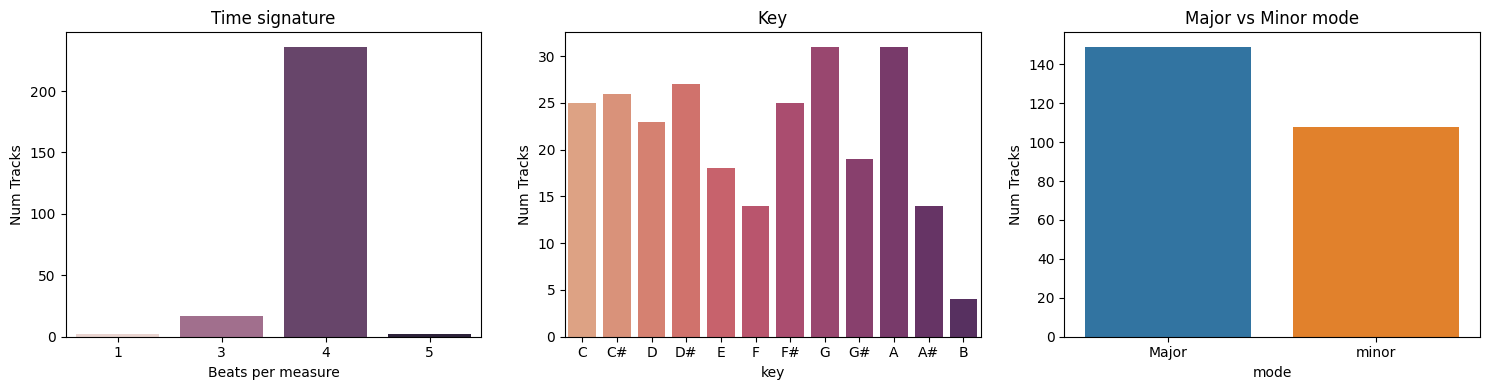

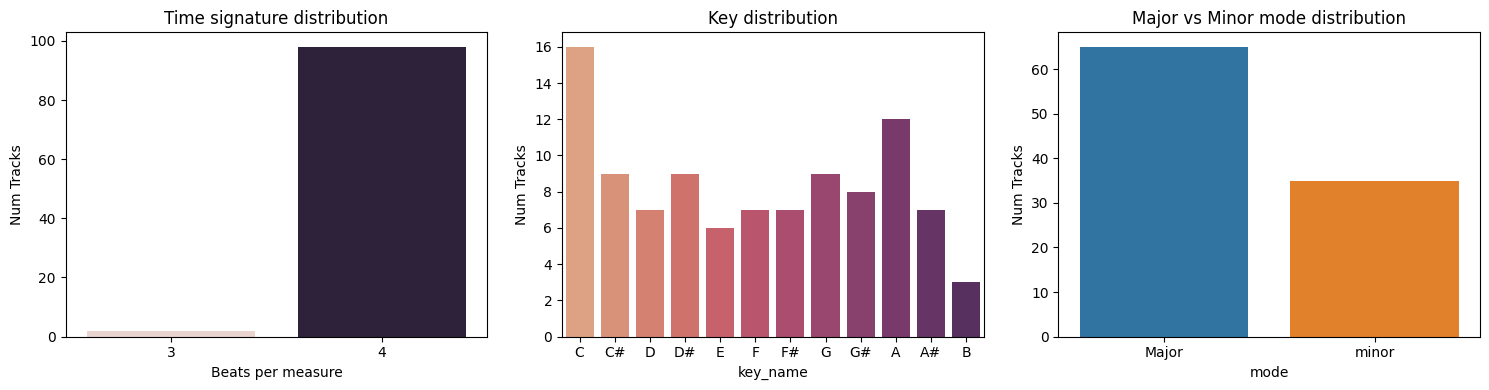

In [156]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(df_obama, x='time_signature', hue='time_signature', legend=False)
plt.xlabel('Beats per measure')
plt.ylabel('Num Tracks')
plt.title('Time signature')

plt.subplot(1, 3, 2)
sns.countplot(df_obama, x='key', hue='key', palette='flare', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Num Tracks')
plt.title('Key')

plt.subplot(1, 3, 3)
sns.countplot(df_obama, x='mode', hue='mode', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['Major', 'minor'])
plt.ylabel('Num Tracks')
plt.title('Major vs Minor mode')

plt.tight_layout(w_pad=2)
plt.show()


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(df_top_100, x='time_signature', hue='time_signature', legend=False)
plt.xlabel('Beats per measure')
plt.ylabel('Num Tracks')
plt.title('Time signature distribution')

plt.subplot(1, 3, 2)
sns.countplot(df_top_100, x='key_name', hue='key_name', palette='flare', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Num Tracks')
plt.title('Key distribution')

plt.subplot(1, 3, 3)
sns.countplot(df_top_100, x='mode', hue='mode', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['Major', 'minor'])
plt.ylabel('Num Tracks')
plt.title('Major vs Minor mode distribution')

plt.tight_layout(w_pad=2)
plt.show()